
# Plug and Play Priors
In this tutorial we will consider a rather atypical proximal algorithm.
In their seminal work, *Venkatakrishnan et al. [2021], Plug-and-Play Priors
for Model Based Reconstruction* showed that the y-update in the ADMM algorithm
can be interpreted as a denoising problem. The authors therefore suggested to
replace the regularizer of the original problem with any denoising algorithm
of choice (even if it does not have a known proximal). The proposed algorithm
has shown great performance in a variety of inverse problems.

As an example, we will consider a simplified MRI experiment, where the
data is created by appling a 2D Fourier Transform to the input model and
by randomly sampling 60% of its values. We will use the famous
[BM3D](https://pypi.org/project/bm3d) as the denoiser, but any other denoiser
of choice can be used instead!

Finally, whilst in the original paper, PnP is associated to the ADMM solver, subsequent
research showed that the same principle can be applied to pretty much any proximal
solver. We will show how to pass a solver of choice to our
:func:`pyproximal.optimization.pnp.PlugAndPlay` solver.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylops
import cv2

import pyproximal
import bm3d

from skimage.restoration import denoise_nl_means, estimate_sigma
from pylops.config import set_ndarray_multiplication

plt.close('all')
np.random.seed(0)
set_ndarray_multiplication(False)

Let's start by loading standard images, and creating the modelling operator

In [2]:
# x = np.load("../testdata/shepp_logan_phantom.npy")
image_number = 8
x = cv2.imread(f"Dataset/Image{image_number}.png")
x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
mindim = np.min(x.shape)
x = x.copy()[:mindim, :mindim]
x = x / x.max()
ny, nx = x.shape

perc_subsampling = 0.6
nxsub = int(np.round(ny * nx * perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny * nx))[:nxsub])
Rop = pylops.Restriction(ny * nx, iava, dtype=np.complex128)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx))

We now create and display the data alongside the model



In [3]:
x.shape

(1200, 1200)

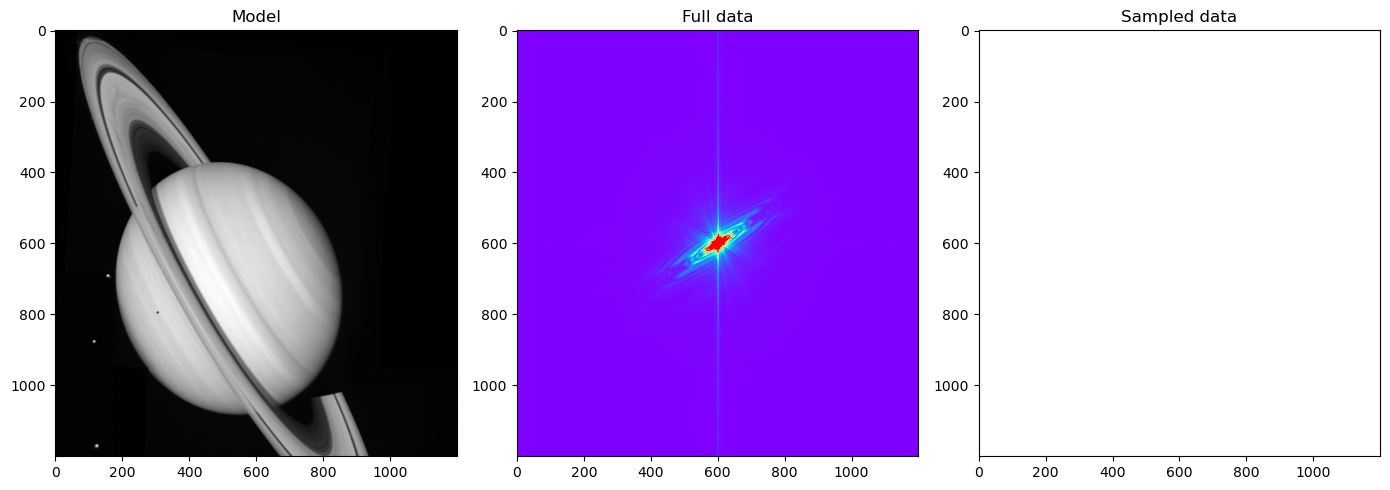

In [4]:
y = Rop * Fop * x.ravel()
yfft = Fop * x.ravel()
yfft = np.fft.fftshift(yfft.reshape(ny, nx))

ymask = Rop.mask(Fop * x.ravel())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("Full data")
axs[1].axis("tight")
axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[2].set_title("Sampled data")
axs[2].axis("tight")
plt.tight_layout()

At this point we create a denoiser instance using the BM3D algorithm and use
as Plug-and-Play Prior to the PG and ADMM algorithms



Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 0.9999999999999982	beta=5.000000e-01
epsg = 1.0	niter = 40
niterback = 100	acceleration = fista

   Itn       x[0]          f           g       J=f+eps*g
     1  -2.75855e-01   3.061e+03   0.000e+00   3.061e+03
     2  -2.53034e-01   7.666e+02   0.000e+00   7.666e+02
     3  -2.37752e-01   1.002e+02   0.000e+00   1.002e+02
     4  -2.28462e-01   2.528e+00   0.000e+00   2.528e+00
     5  -2.23367e-01   4.289e+00   0.000e+00   4.289e+00
     6  -2.20187e-01   4.185e+00   0.000e+00   4.185e+00
     7  -2.18812e-01   1.869e+00   0.000e+00   1.869e+00
     8  -2.17733e-01   1.137e+00   0.000e+00   1.137e+00
     9  -2.16485e-01   1.163e+00   0.000e+00   1.163e+00
    10  -2.15046e-01   1.172e+00   0.000e+00   1.172e+00
    13  -2.09681e-01   1.131e+00   0.000e+00   1.131e

c:\Users\thari\anaconda3\envs\FM\lib\site-packages\pyproximal\optimization\primal.py:685: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = '%6g  %12.5e  %10.3e  %10.3e  %10.3e' % \


     1  -1.39422e-01   1.501e+04   0.000e+00   1.501e+04
     2  -1.96035e-01   6.050e+03   0.000e+00   6.050e+03
     3  -2.18219e-01   2.470e+03   0.000e+00   2.470e+03
     4  -2.26254e-01   9.534e+02   0.000e+00   9.534e+02
     5  -2.27542e-01   3.471e+02   0.000e+00   3.471e+02
     6  -2.26886e-01   1.207e+02   0.000e+00   1.207e+02
     7  -2.25422e-01   4.091e+01   0.000e+00   4.091e+01
     8  -2.25402e-01   1.398e+01   0.000e+00   1.398e+01
     9  -2.24082e-01   5.196e+00   0.000e+00   5.196e+00
    10  -2.22588e-01   2.402e+00   0.000e+00   2.402e+00
    13  -2.18770e-01   1.166e+00   0.000e+00   1.166e+00
    17  -2.16895e-01   1.117e+00   0.000e+00   1.117e+00
    21  -2.15247e-01   1.113e+00   0.000e+00   1.113e+00
    25  -2.13531e-01   1.116e+00   0.000e+00   1.116e+00
    29  -2.11794e-01   1.121e+00   0.000e+00   1.121e+00
    32  -2.10663e-01   1.128e+00   0.000e+00   1.128e+00
    33  -2.10272e-01   1.130e+00   0.000e+00   1.130e+00
    34  -2.09878e-01   1.131e+0

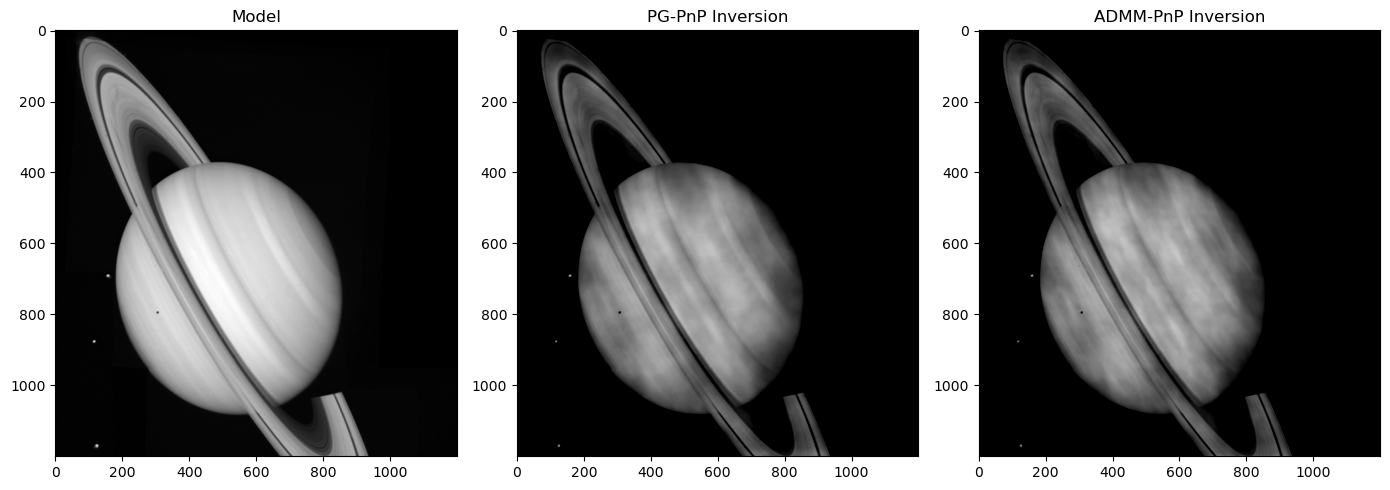

In [5]:
def callback(x, xtrue, errhist):
    errhist.append(np.linalg.norm(x - xtrue))

Op = Rop * Fop
L = np.real((Op.H*Op).eigs(neigs=1, which='LM')[0])
tau = 1./L
sigma = 0.05

l2 = pyproximal.proximal.L2(Op=Op, b=y.ravel(), niter=50, warm=True)

# BM3D denoiser
# denoiser = lambda x, tau: bm3d.bm3d(np.real(x), sigma_psd=sigma * tau,
#                                     stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

# NLM denoiser
patch_kw = dict(patch_size=5,       # 5x5 patches
                patch_distance=60,  # 121x121 search area
                channel_axis = -1,
                fast_mode=True)

def denoiser (x, tau):
    x = np.real(x)
    sigma_est = np.mean(estimate_sigma(x, channel_axis=-1))
    x = x[:,:, np.newaxis]
    return denoise_nl_means(x, h=0.8 * sigma_est, sigma=sigma_est*tau, **patch_kw)  

# PG-Pnp
errhistpg = []
xpnppg = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, x.shape,
                                                 solver=pyproximal.optimization.primal.ProximalGradient,
                                                 tau=tau, x0=np.zeros(x.size),
                                                 niter=40,
                                                 acceleration='fista',
                                                 show=True,
                                                 callback=lambda xx: callback(xx, x.ravel(),
                                                                              errhistpg))
xpnppg = np.real(xpnppg.reshape(x.shape))

# ADMM-PnP
errhistadmm = []
xpnpadmm = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, x.shape,
                                                   solver=pyproximal.optimization.primal.ADMM,
                                                   tau=tau, x0=np.zeros(x.size),
                                                   niter=40, show=True,
                                                   callback=lambda xx: callback(xx, x.ravel(),
                                                                                errhistadmm))[0]
xpnpadmm = np.real(xpnpadmm.reshape(x.shape))

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnppg, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("PG-PnP Inversion")
axs[1].axis("tight")
axs[2].imshow(xpnpadmm, vmin=0, vmax=1, cmap="gray")
axs[2].set_title("ADMM-PnP Inversion")
axs[2].axis("tight")
plt.tight_layout()

Finally, let's compare the error convergence of the two variations of PnP



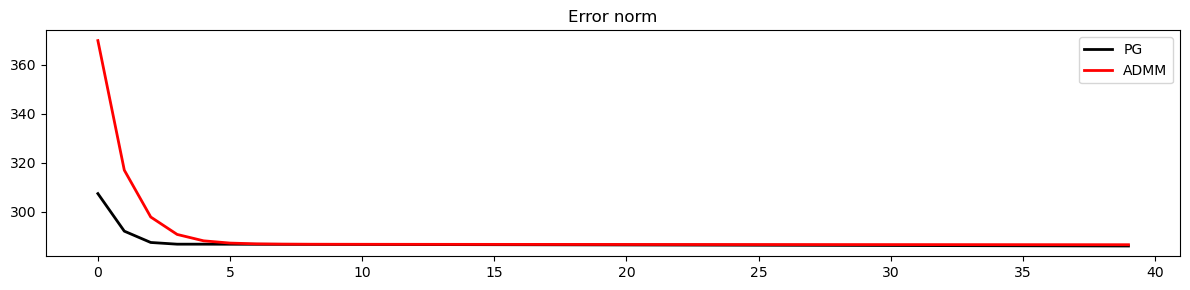

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(errhistpg, 'k', lw=2, label='PG')
plt.plot(errhistadmm, 'r', lw=2, label='ADMM')
plt.title("Error norm")
plt.legend()
plt.tight_layout()

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.0	beta=5.000000e-01
epsg = 1.0	niter = 40
niterback = 100	acceleration = fista

   Itn       x[0]          f           g       J=f+eps*g
     1  -2.42488e-01   3.076e+03   0.000e+00   3.076e+03
     2  -2.14296e-01   7.829e+02   0.000e+00   7.829e+02
     3  -1.93839e-01   1.149e+02   0.000e+00   1.149e+02
     4  -1.85761e-01   1.422e+01   0.000e+00   1.422e+01
     5  -1.84142e-01   1.426e+01   0.000e+00   1.426e+01
     6  -1.85918e-01   1.379e+01   0.000e+00   1.379e+01
     7  -1.88907e-01   1.159e+01   0.000e+00   1.159e+01
     8  -1.91851e-01   1.094e+01   0.000e+00   1.094e+01
     9  -1.94530e-01   1.093e+01   0.000e+00   1.093e+01
    10  -1.96578e-01   1.082e+01   0.000e+00   1.082e+01
    13  -2.01592e-01   1.046e+01   0.000e+00   1.046e+01
    17  -2.

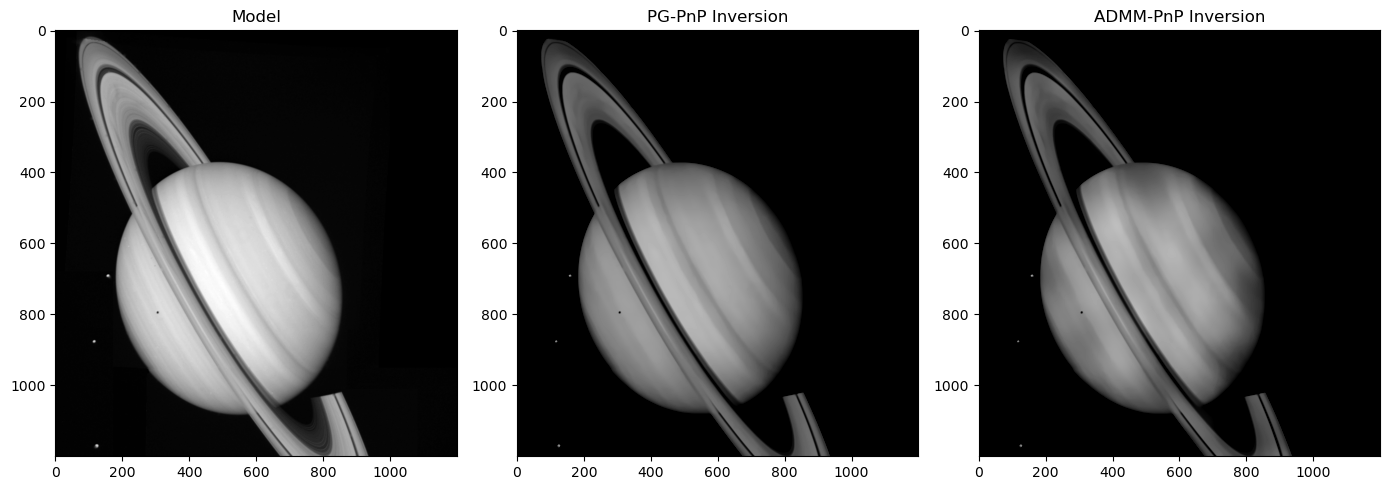

In [7]:
def callback(x, xtrue, errhist):
    errhist.append(np.linalg.norm(x - xtrue))

Op = Rop * Fop
L = np.real((Op.H*Op).eigs(neigs=1, which='LM')[0])
tau = 1./L
sigma = 0.05

l2 = pyproximal.proximal.L2(Op=Op, b=y.ravel(), niter=50, warm=True)

# BM3D denoiser
denoiser = lambda x, tau: bm3d.bm3d(np.real(x), sigma_psd=sigma * tau,
                                    stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

# # NLM denoiser
# patch_kw = dict(patch_size=5,       # 5x5 patches
#                 patch_distance=60,  # 121x121 search area
#                 channel_axis = -1,
#                 fast_mode=True)

# def denoiser (x, tau):
#     x = np.real(x)
#     sigma_est = np.mean(estimate_sigma(x, channel_axis=-1))
#     x = x[:,:, np.newaxis]
#     return denoise_nl_means(x, h=0.8 * sigma_est, sigma=sigma_est*tau, **patch_kw)  

# PG-Pnp
errhistpg = []
xpnppg = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, x.shape,
                                                 solver=pyproximal.optimization.primal.ProximalGradient,
                                                 tau=tau, x0=np.zeros(x.size),
                                                 niter=40,
                                                 acceleration='fista',
                                                 show=True,
                                                 callback=lambda xx: callback(xx, x.ravel(),
                                                                              errhistpg))
xpnppg = np.real(xpnppg.reshape(x.shape))

# ADMM-PnP
errhistadmm = []
xpnpadmm = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, x.shape,
                                                   solver=pyproximal.optimization.primal.ADMM,
                                                   tau=tau, x0=np.zeros(x.size),
                                                   niter=40, show=True,
                                                   callback=lambda xx: callback(xx, x.ravel(),
                                                                                errhistadmm))[0]
xpnpadmm = np.real(xpnpadmm.reshape(x.shape))

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnppg, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("PG-PnP Inversion")
axs[1].axis("tight")
axs[2].imshow(xpnpadmm, vmin=0, vmax=1, cmap="gray")
axs[2].set_title("ADMM-PnP Inversion")
axs[2].axis("tight")
plt.tight_layout()

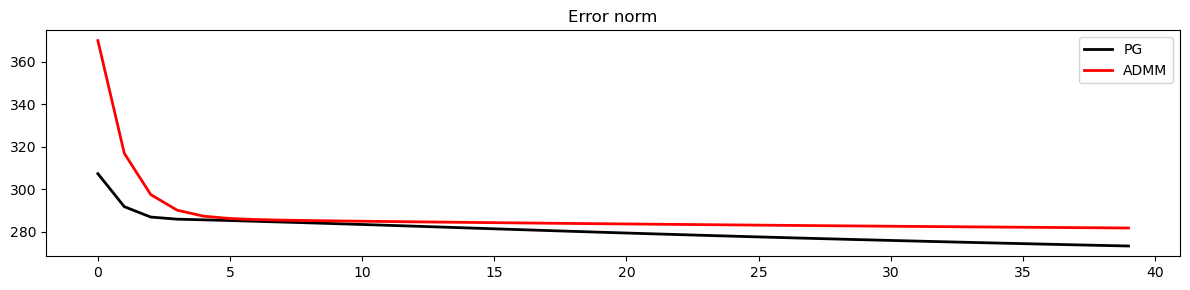

In [8]:
plt.figure(figsize=(12, 3))
plt.plot(errhistpg, 'k', lw=2, label='PG')
plt.plot(errhistadmm, 'r', lw=2, label='ADMM')
plt.title("Error norm")
plt.legend()
plt.tight_layout()